<div align="right"><em>Машинне навчання. Лабораторний практикум</em></div>

# Лабораторна робота №7
## Навчання без вчителя: метод головних компонент і кластеризація


---


## Завдання

Необхідно:
- розібратися з тим, як працюють методи зниження розмірності і кластеризації даних; 
- ще раз попрактикуватися в задачі класифікації;
- дати відповіді (з написанням коду) на всі запитання сформульовані в лабораторній роботі.

#### Опис даних

Будемо працювати з набором даних [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Дані надходять з акселерометрів і гіроскопів мобільних телефонів Samsung Galaxy S3 (докладніше про ознаки – за посиланням на UCI вище), також відомий вид активності людини з телефоном в кишені – чи ходила вона, стояла, лежала, сиділа або йшла вгору/вниз по сходах.

Спочатку уявлятимемо, що вид активності нам невідомий, і спробуємо кластеризувати людей суто на основі наявних ознак. Потім розв'яжемо задачу визначення виду фізичної активності саме як задачу класифікації.

## Виконання завдання

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("../data/samsung_HAR/samsung_train.txt")
y_train = np.loadtxt("../data/samsung_HAR/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("../data/samsung_HAR/samsung_test.txt")
y_test = np.loadtxt("../data/samsung_HAR/samsung_test_labels.txt").astype(int)

In [3]:
# Перевіримо розмірності
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризації нам не потрібен вектор міток, тому об'єднаємо `X_train` з `X_test` та `y_train` з `y_test`.

In [4]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

Визначимо кількість унікальних значень міток цільового класу.

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [6]:
n_classes = np.unique(y).size

n_classes

6

Ці мітки відповідають:
- 1 - ходьбі
- 2 - підйому вгору по сходах
- 3 - спуску по сходах
- 4 - сидінню
- 5 - стоянню
- 6 - лежанню

Відмасштабуйте вибірку за допомогою `StandardScaler` з параметрами за замовчуванням.

In [7]:
# Ваш код тут
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Знижуємо розмірність за допомогою PCA, залишаючи стільки компонент, скільки потрібно для того, щоб пояснити як мінімум 90% дисперсії вихідних (відмасштабованих) даних. Використовуйте відмасштабовану вибірку і зафіксуйте `random_state` (константа RANDOM_STATE).

In [8]:
# pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
# X_pca = pca.fit_transform(X_scaled)
pca = PCA(n_components=0.9, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

**Запитання 1:** <br>
Яку мінімальну кількість головних компонент потрібно виділити, щоб пояснити 90% дисперсії вихідних (відмасштабованих) даних?

**Варіанти:**
- 56 
- [X] 65
- 66
- 193

In [9]:
# Ваш код тут
X_pca.shape[1]

65

**Запитання 2:** <br>
Скільки відсотків дисперсії припадає на першу головну компоненту? Округліть до цілих відсотків.

**Варіанти:**
- 45
- [X] 51
- 56
- 61

In [10]:
# Ваш код тут
round(pca.explained_variance_ratio_[0] * 100)

51

Візуалізуйте дані в проекції на перші дві головні компоненти.

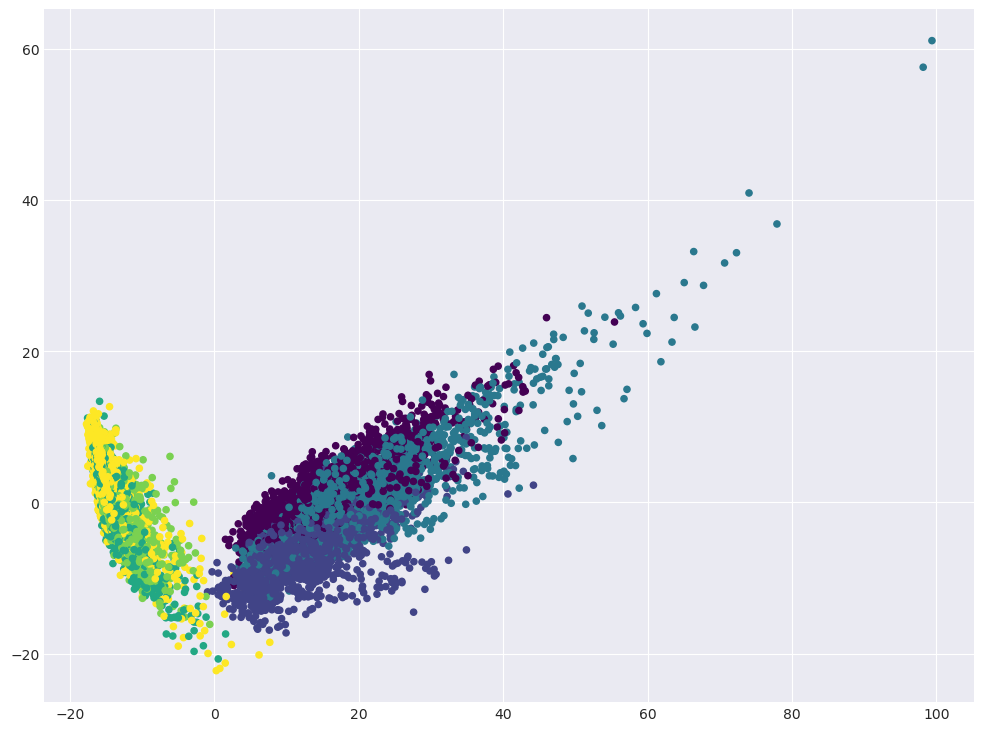

In [11]:
# Ваш код тут
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis');

**Запитання 3:** <br>
Якщо все вийшло правильно, Ви побачите *певну кількість* кластерів, майже ідеально відокремлених один від одного. Які види активності входять в ці кластери? <br>

**Варіанти:**
- 1 кластер: всі 6 активностей
- [X] 2 кластери: (ходьба, підйом вгору по сходах, спуск по сходах) і (сидіння, стояння, лежання)
- 3 кластери: (ходьба), (підйом вгору по сходах, спуск по сходах) і (сидіння, стояння, лежання)
- 6 кластерів

------------------------------

Зробіть кластеризацію даних методом `KMeans`, навчивши модель на даних зі зниженою за рахунок PCA розмірністю. В даному випадку ми підкажемо, що потрібно шукати саме 6 кластерів, але в загальному випадку ми не будемо знати, скільки кластерів треба шукати.

параметри:

- `n_clusters` = n_classes (кількість унікальних міток цільового класу)
- `n_init` = 100
- `random_state` = RANDOM_STATE (для відтворюваності результату)

Інші параметри зі значеннями за замовчуванням.

In [12]:
# Ваш код тут
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

Візуалізують дані в проекції на перші дві головні компоненти. Розфарбуйте точки відповідно до отриманих міток кластерів.

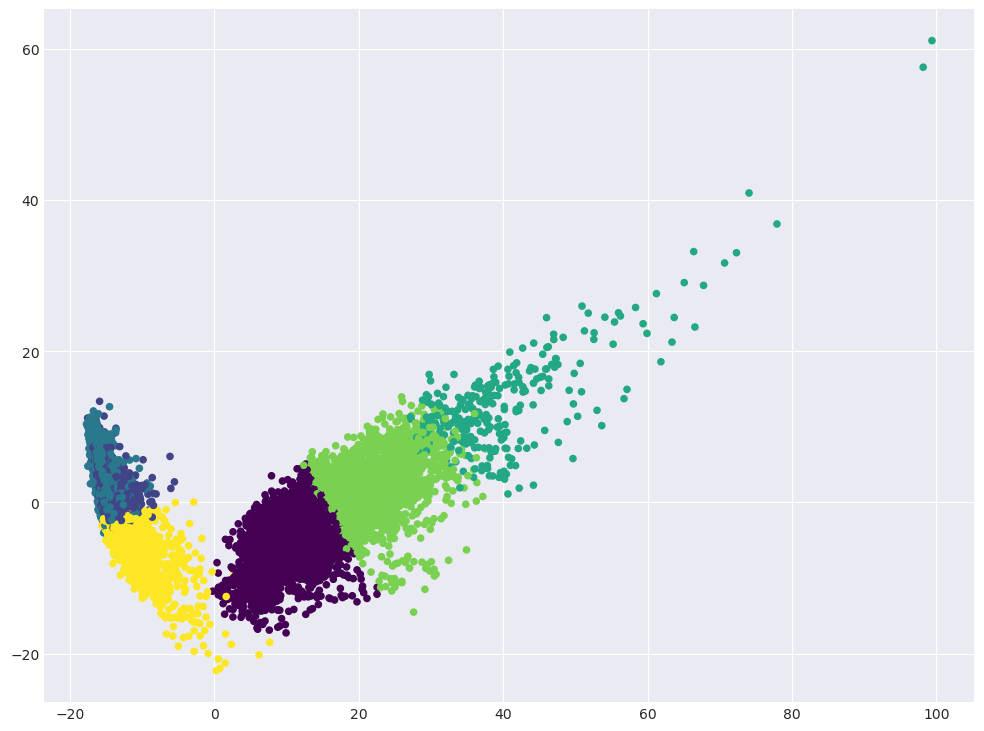

In [13]:
# Ваш код здесь
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20,  cmap='viridis');

Подивіться на відповідність між мітками кластерів і вихідними мітками класів і на те, які види активностей алгоритм `KMeans` плутає.

In [14]:
tab = pd.crosstab(y, cluster_labels, margins = True)
tab.index = ['ходьба', 'підйом вгору по сходах',
             'спуск по сходах', 'сидіння', 'стояння', 'лежання', 'всього']
tab.columns = ['cluster' + str(i + 1) for i in range (6)] + ['всього']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,всього
ходьба,903,0,0,78,741,0,1722
підйом вгору по сходах,1241,0,0,5,296,2,1544
спуск по сходах,320,0,0,196,890,0,1406
сидіння,1,1235,91,0,0,450,1777
стояння,0,1344,0,0,0,562,1906
лежання,5,52,1558,0,0,329,1944
всього,2470,2631,1649,279,1927,1343,10299


Бачимо, що кожному класу (тобто кожній активності) відповідають декілька кластерів. Давайте подивимося на максимальну частку об'єктів в класі, віднесених до якогось одного кластера. Це буде простою метрикою, що характеризує, наскільки легко клас відділяється від інших при кластеризації.

Приклад: якщо для класу "спуск по сходах", в якому 1406 об'єктів, розподіл кластерів такий:
 - кластер 2 – 320
 - кластер 3 – 890
 - кластер 4 – 196,
 
то така частка буде 890 / 1406 $\approx$ 0.63.
 

**Запитання 4:** <br>
Який вид активності відокремився від інших найкраще в термінах простої метрики, описаної вище? <br>

**Варіанти:**
- ходьба
- стояння
- спуск по сходах
- [X] перераховані варіанти не підходять

In [15]:
# Ваш код тут
# iloc[:-1, :-1] 👉 exclude row and column of overall
# max(axis=1) 👉 get max every row
# .values 👉 get sum of every raw
pd.Series(tab.iloc[:-1, :-1].max(axis=1) / tab.iloc[:-1, -1].values)

ходьба                    0.524390
підйом вгору по сходах    0.803756
спуск по сходах           0.633001
сидіння                   0.694992
стояння                   0.705142
лежання                   0.801440
dtype: float64

Видно, що kMeans не дуже добре відрізняє види активності один від одного. Використовуйте метод ліктя, щоб вибрати оптимальну кількість кластерів. Параметри алгоритму і дані використовуємо ті самі, що і раніше, міняємо тільки `n_clusters`.

In [16]:
# Ваш код тут
inertia = []
for k in tqdm(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

  0%|          | 0/6 [00:00<?, ?it/s]

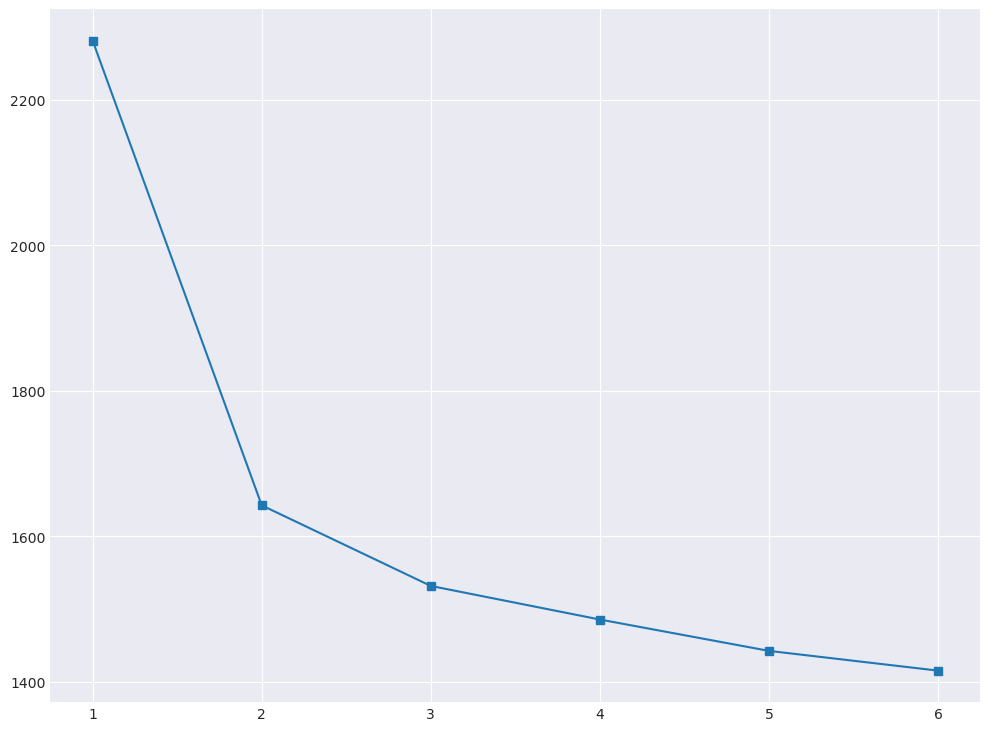

In [17]:
plt.plot(range(1, n_classes + 1), inertia, marker='s');

**Запитання 5:** <br>
Яку кількість кластерів оптимально вибрати, згідно з методом ліктя? <br>

**Варіанти:**
- 1
- [X] 2
- 3
- 4

------------------------

Спробуємо ще один метод кластеризації, який описувався в лекції – агломеративну кластеризацію.

In [18]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)

Порахуйте Adjusted Rand Index ( `sklearn.metrics`) для отриманого розбиття на кластери і для` KMeans` з параметрами із завдання до 4-ого запитання.

In [19]:
# Ваш код тут
print("KMeans: Adjusted Rand Index = ", metrics.adjusted_rand_score(y, cluster_labels))
print("Agglomerative CLustering: Adjusted Rand Index =", metrics.adjusted_rand_score(y, ag.labels_))

KMeans: Adjusted Rand Index =  0.4198070012602345
Agglomerative CLustering: Adjusted Rand Index = 0.49362763373004886


**Запитання 6:** <br>
Виберіть всі вірні твердження.<br>

**Варіанти:**
- [X] Згідно ARI (Adjusted Rand Index), KMeans впорався з кластеризациєю гірше, ніж Agglomerative Clustering
- [X] Для ARI не має значення які саме мітки присвоєні кластерам, має значення тільки розбиття об'єктів на кластери
- [X] У разі випадкового розбиття на кластери ARI буде близький до нуля

-------------------------------

Можна помітити, що задача не дуже добре розв'язується саме як задача кластеризації, якщо виділяти декілька кластерів (> 2). Давайте тепер розв'яжемо задачу класифікації, згадавши, що дані у нас розмічені.

Для класифікації використовуйте метод опорних векторів – клас `sklearn.svm.LinearSVC`. Ми в курсі окремо не розглядали цей алгоритм, але він дуже відомий, почитати про нього можна, наприклад, [тут](https://cs231n.github.io/linear-classify/#svmvssoftmax).

Налаштуйте для `LinearSVC` гіперпараметр` C` за допомогою `GridSearchCV`.

- Навчіть новий `StandardScaler` на навчальній вибірці (з усіма вихідними ознаками), застосуйте масштабування до тестової вибірки 
- В `GridSearchCV` вкажіть `cv` = 3.

In [20]:
# Ваш код тут
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=3000, dual=True)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [22]:
# Ваш код тут
best_svc = GridSearchCV(svc, svc_params, cv=3, n_jobs=4, verbose=1)
best_svc.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3, estimator=LinearSVC(max_iter=3000, random_state=17),
             n_jobs=4, param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}, verbose=1)

In [23]:
# Ваш код тут
best_svc.best_params_, best_svc.best_score_

({'C': 0.1}, 0.9382506099134881)

**Запитання 7:** <br>
Яке значення гіперпараметра `C` було вибрано кращим за підсумками крос-валідації? <br>

**Варіанти:**
- 0.001
- 0.01
- [X] 0.1
- 1
- 10

In [24]:
y_predicted = best_svc.predict(X_test_scaled)

In [25]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'підйом вгору по сходах', 'спуск по сходах',
             'сидіння', 'стояння', 'лежання', 'всього']
tab.columns = tab.index
tab

,ходьба,підйом вгору по сходах,спуск по сходах,сидіння,стояння,лежання,всього
ходьба,494,2,0,0,0,0,496
підйом вгору по сходах,12,459,0,0,0,0,471
спуск по сходах,2,4,413,1,0,0,420
сидіння,0,4,0,426,61,0,491
стояння,0,0,0,15,517,0,532
лежання,0,0,0,0,11,526,537
всього,508,469,413,442,589,526,2947


**Запитання 8:** <br>
Який вид активності SVM визначає найгірше в термінах точності? Повноти? <br>

**Варіанти:**
- за точністю – підйом вгору по сходах, за повнотою – лежання
- за точністю – лежання, за повнотою – сидіння
- за точністю – ходьба, за повнотою – ходьба
- [X] за точністю – стояння, за повнотою – сидіння

In [26]:
# Ваш код тут
pd.Series(tab.iloc[-1, :-1].values - tab.iloc[:-1, :-1].max(axis=0)).nlargest(1)

стояння    72
dtype: int64

Нарешті, виконайте те ж саме, що в 7 запитанні, тільки додавши PCA.

- Використовуйте вибірки `X_train_scaled` і `X_test_scaled`
- Навчіть той самий PCA, що раніше, на відмасштабованій навчальній вибірці, застосуєте перетворення до тестової
- Налаштуйте гіперпараметр `C` на крос-валідації за навчальною вибіркою з PCA-перетворенням. Ви помітите, наскільки це проходить швидше, ніж раніше.

**Запитання 9:** <br>
Яка різниця між кращою якістю (часткою вірних відповідей) на крос-валідації в разі всіх 561 вихідних ознак і в другому випадку, коли застосовувався метод головних компонент? Округліть до цілих відсотків.<br>

**Варіанти:**
- Якість однакова
- 2%
- [X] 4%
- 10%
- 20%

In [27]:
# Ваш код тут
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

svc = LinearSVC(random_state=RANDOM_STATE, max_iter=9000, dual=True)

best_svc_pca = GridSearchCV(svc, svc_params, cv=3, n_jobs=4, verbose=1)
best_svc_pca.fit(X_train_pca, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3, estimator=LinearSVC(max_iter=9000, random_state=17),
             n_jobs=4, param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}, verbose=1)

In [28]:
best_svc_pca.best_params_, best_svc_pca

({'C': 0.1},
 GridSearchCV(cv=3, estimator=LinearSVC(max_iter=9000, random_state=17),
              n_jobs=4, param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}, verbose=1))

In [29]:
print(round(100 * (best_svc_pca.best_score_ - best_svc.best_score_)), '%', sep='')

-4%


**Запитання 10:** <br>
Виберіть всі вірні твердження:

**Варіанти:**
- Метод головних компонент в даному випадку дозволив зменшити час навчання моделі, при цьому якість (частка вірних відповідей на крос-валідації) дуже постраждала, більш ніж на 10%
- [X] PCA можна використовувати для візуалізації даних, однак для цієї задачі є методи, що підходять краще, наприклад, tSNE. Зате PCA має меншу обчислювальну складність
- [X] PCA будує лінійні комбінації вихідних ознак, і в деяких задачах вони можуть погано інтерпретуватися людиною

<details>
<summary>...</summary>

- Метод головних компонент справді дозволив значно скоротити час навчання моделі, але якість постраждала не так сильно - лише на 4%.
- Для багатовимірної візуалізації даних краще використовувати методи множинного навчання, зокрема, tSNE. При цьому метрики, що оцінюють якість візуалізації, ще не винайдено, але tSNE широко використовується саме тому, що в деяких випадках він будує "хороші" картинки, що відображають структуру даних, як у випадку з MNIST.
- Лінійні комбінації ознак, які будує PCA, часто погано інтерпретуються людиною, наприклад, "0,574 * зарплата + 0,234 * кількість_дітей"

</details>